In [53]:
import os
import snirf
import numpy as np
import pandas as pd

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from typing import Union
from behav_analysis import Data_Functions, Participant_Behav, load_results


def sort_dict(dictionary: dict, sort_by: str) -> dict:
    """
    Sort a dictionary by keys or values.

    Args:
        dictionary (dict): Dictionary to sort.
        sort_by (str): How to sort to dictionary: by "keys" or by "values".

    Raises:
        Exception: Invalid sort_by argument.

    Returns:
        dict: Sorted dictionary.
    """
    if "key" in sort_by.lower():
        return dict(sorted(dictionary.items(), key=lambda item: item[0]))
    elif "value" in sort_by.lower():
        return dict(sorted(dictionary.items(), key=lambda item: item[1]))
    else:
        raise Exception("Invalid 'sort_by' argument. Must be 'key' or 'value'.")


class Process_Flow:
    """
    This class contains functions for processing Kernel Flow data.
    # NOTE: Wrapper around snirf.Snirf
    """

    def __init__(self, filepath: str) -> None:
        """
        Initialize by loading SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.
        """
        self.snirf_file = self.load_snirf(filepath)

    def load_snirf(self, filepath: str) -> snirf.Snirf:
        """
        Load SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.

        Returns:
            snirf.Snirf: SNIRF file object.
        """
        return snirf.Snirf(filepath, "r+", dynamic_loading=True)

    def get_time_origin(self, fmt: str = "datetime") -> Union[datetime.datetime, float]:
        """
        Get the time origin (start time) from the SNIRF file.

        Args:
            fmt (str, optional): Format to get the time origin in: "datetime" or "timestamp". Defaults to "datetime".

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            Union[datetime.datetime, float]:
                datetime.datetime: Time origin datetime.
                -or-
                float: Time origin timestamp.
        """
        start_date = self.snirf_file.nirs[0].metaDataTags.MeasurementDate
        start_time = self.snirf_file.nirs[0].metaDataTags.MeasurementTime
        start_str = start_date + " " + start_time
        time_origin = datetime.datetime.strptime(
            start_str, "%Y-%m-%d %H:%M:%S"
        ) - datetime.timedelta(
            hours=4
        )  # 4 hour offset
        if fmt.lower() == "datetime":
            return time_origin
        elif fmt.lower() == "timestamp":
            return datetime.datetime.timestamp(time_origin)
        else:
            raise Exception(
                "Invalid 'fmt' argument. Must be 'datetime' or 'timestamp'."
            )

    def get_subject_ID(self) -> str:
        """
        Get the subject ID from the SNIRF file.

        Returns:
            str: Subject ID.
        """
        return self.snirf_file.nirs[0].metaDataTags.SubjectID

    def get_time_rel(self) -> np.ndarray:
        """
        Get the relative time array from the SNIRF file.

        Returns:
            np.ndarray: Relative time array.
        """
        return self.snirf_file.nirs[0].data[0].time

    def get_time_abs(self, fmt: str = "datetime") -> np.ndarray:
        """
        Convert relative time array into an absolute time array.

        Args:
            fmt (str, optional): Format to get the time array in: "datetime" or "timestamp". Defaults to "datetime".

        Returns:
            np.ndarray: Absolute time array.
        """
        time_rel = self.get_time_rel()
        if fmt.lower() == "datetime":
            time_origin_dt = self.get_time_origin("datetime")
            return np.array(
                [
                    datetime.timedelta(seconds=time_rel[i]) + time_origin_dt
                    for i in range(len(time_rel))
                ]
            )
        elif fmt.lower() == "timestamp":
            time_origin_ts = self.get_time_origin("timestamp")
            return time_rel + time_origin_ts

    def get_data(
        self, fmt: str = "array", cols: list[int | list | tuple] = None
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        Get timeseries data from the SNIRF file.

        Args:
            fmt (str): Format of data (np.ndarray or pd.DataFrame). Defaults to "array".
            cols (list[int | list | tuple]): Data cols to select. Single col, list of cols, or slice of cols.
                                             Defaults to None (all columns).

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            np.ndarray: Timeseries data array.
        """
        if cols or cols == 0:
            if isinstance(cols, tuple):
                data = (
                    self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols[0] : cols[1]]
                )
            else:
                data = self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols]
        else:
            data = self.snirf_file.nirs[0].data[0].dataTimeSeries

        if "array" in fmt.lower():
            return data
        elif "dataframe" in fmt.lower():
            return pd.DataFrame(data)
        else:
            raise Exception("Invalid fmt argument. Must be 'array' or 'dataframe'.")

    def get_unique_data_types(self) -> list:
        """
        Get unique data types from the SNIRF file.

        Returns:
            list: Unique data types.
        """
        data_types = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type = self.snirf_file.nirs[0].data[0].measurementList[i].dataType
            if data_type not in data_types:
                data_types.append(data_type)
        return data_types

    def get_unique_data_type_labels(self) -> list:
        """
        Get unique data type labels from the SNIRF file.

        Returns:
            list: Unique data type labels.
        """
        data_type_labels = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type_label = (
                self.snirf_file.nirs[0].data[0].measurementList[i].dataTypeLabel
            )
            if data_type_label not in data_type_labels:
                data_type_labels.append(data_type_label)
        return data_type_labels

    def create_source_dict(self) -> dict:
        """
        Count the occurrences of each source index.

        Returns:
            dict: Counts for each source index.
        """
        source_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            source = self.snirf_file.nirs[0].data[0].measurementList[i].sourceIndex
            source_dict[source] = source_dict.get(source, 0) + 1
        source_dict = sort_dict(source_dict, "keys")
        return source_dict

    def create_detector_dict(self) -> dict:
        """
        Count the occurrences of each detector index.

        Returns:
            dict: Counts for each detector index.
        """
        detector_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            detector = self.snirf_file.nirs[0].data[0].measurementList[i].detectorIndex
            detector_dict[detector] = detector_dict.get(detector, 0) + 1
        detector_dict = sort_dict(detector_dict, "keys")
        return detector_dict


class Participant_Flow:
    """
    This class contains functions, data structures, and info necessary for
    processing Kernel Flow data from the experiments.
    """

    def __init__(self, par_num):
        self.data_fun = Data_Functions()
        self.par_behav = Participant_Behav(par_num)
        self.par_num, self.par_ID = self.data_fun.process_par(par_num)
        data_dir = r"C:\Kernel\participants"
        self.flow_data_dir = os.path.join(data_dir, self.par_ID, "flow_data")
        self.plot_color_dict = {
            0: "blue",
            1: "green",
            2: "red",
            3: "yellow",
            4: "pink",
            5: "orange",
        }

    def load_flow_session(
        self, session: list[str | int], wrapper: bool = False
    ) -> snirf.Snirf:
        """
        Load Kernel Flow data for an experiment session.

        Args:
            session list[str | int]: Experiment session.
            wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                     Defaults to false.

        Raises:
            Exception: Invalid session number argument.

        Returns:
            snirf.Snirf: SNIRF file object.
            -or-
            Process_Flow object for each experiment session.
        """
        if isinstance(session, str):
            if "session" not in session:
                session = f"session_{session}"
        elif isinstance(session, int):
            session = f"session_{session}"
        try:
            session_dir = os.path.join(self.flow_data_dir, session)
            filename = os.listdir(session_dir)[0]
            filepath = os.path.join(session_dir, filename)
            if wrapper:
                return Process_Flow(filepath)
            else:
                return Process_Flow(filepath).snirf_file
        except:
            print("Invalid session number.")
            raise

    def load_flow_exp(self, exp_name: str) -> pd.DataFrame:
        """
        Load Kernel Flow data for the time frame of a specified experiment.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            pd.DataFrame: Kernel Flow data for an experiment.
        """
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        flow_session = self.load_flow_session(session, wrapper=True)
        start_dt = self.par_behav.get_start_dt(exp_name)
        end_dt = self.par_behav.get_end_dt(exp_name)
        time_abs_dt = flow_session.get_time_abs("datetime")
        start_idx = self.par_behav.get_start_index_dt(time_abs_dt, start_dt)
        end_idx = self.par_behav.get_end_index_dt(time_abs_dt, end_dt)
        exp_time_abs = time_abs_dt[start_idx:end_idx]
        flow_data = flow_session.get_data("dataframe")
        flow_data.insert(0, "datetime", time_abs_dt)
        return flow_data.iloc[start_idx:end_idx, :]

    def create_flow_session_dict(self, wrapper: bool = False) -> dict:
        """
        Create a dictionary of Kernel Flow data for all experiment sessions.

        wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                 Default to false.

        Returns:
            dict: Kernel Flow data for all experiment sessions.
                keys:
                    "session_1001", "session_1002", "session_1003"
                values:
                    SNIRF file object for each experiment session
                    -or-
                    Process_Flow object for each experiment session
        """
        flow_session_dict = {}
        for session in self.par_behav.session_dict.keys():
            flow_session_dict[session] = self.load_flow_session(session, wrapper)
        return flow_session_dict

    def plot_flow_session(self, session: str) -> None:
        flow_session = self.load_flow_session(session, wrapper=True)
        time_abs_dt = flow_session.get_time_abs("datetime")
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        ax.plot(
            time_abs_dt, flow_session.get_data(cols=0)
        )  # NOTE: get_data argument is a placeholder
        for exp_name in self.par_behav.session_dict[session]:
            exp_start_dt = self.par_behav.get_start_dt(exp_name)
            exp_end_dt = self.par_behav.get_end_dt(exp_name)
            ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvspan(
                exp_start_dt,
                exp_end_dt,
                color=self.par_behav.exp_color_dict[exp_name],
                alpha=0.4,
                label=exp_name,
            )
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")
        ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor="white", framealpha=1)

    def plot_flow_exp(self, exp_name: str) -> None:
        flow_exp = self.load_flow_exp(exp_name)
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        ax.plot(
            flow_exp["datetime"], flow_exp.iloc[:, 0 + 1], color="black"
        )  # NOTE: placeholder column
        exp_start_dt = self.par_behav.get_start_dt(exp_name)
        exp_end_dt = self.par_behav.get_end_dt(exp_name)
        ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
        ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
        results_dir = r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\results\behavioral"  # NOTE: temporary
        exp_results = load_results(results_dir, exp_name, self.par_num)
        exp_title = self.par_behav.format_exp_name(exp_name)

        num_rows = exp_results.shape[0]
        for _, row in exp_results.iterrows():
            try:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "stim"
                )
                stim = row["stim"]
                label = self.par_behav.format_exp_name(row["stim"])
            except KeyError:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "block"
                )
                stim = row["block"]
                label = self.par_behav.format_exp_name(row["block"])
            color_index = uni_stim_dict[stim]
            try:
                stim_start = datetime.datetime.fromtimestamp(row["stim_start"])
                stim_end = datetime.datetime.fromtimestamp(row["stim_end"])
                ax.axvspan(
                    stim_start,
                    stim_end,
                    color=self.plot_color_dict[color_index],
                    alpha=0.4,
                    label=label,
                )
            except ValueError:
                print("Error while plotting.")

        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")
        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        plt.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Stimulus",
        )


participant_01


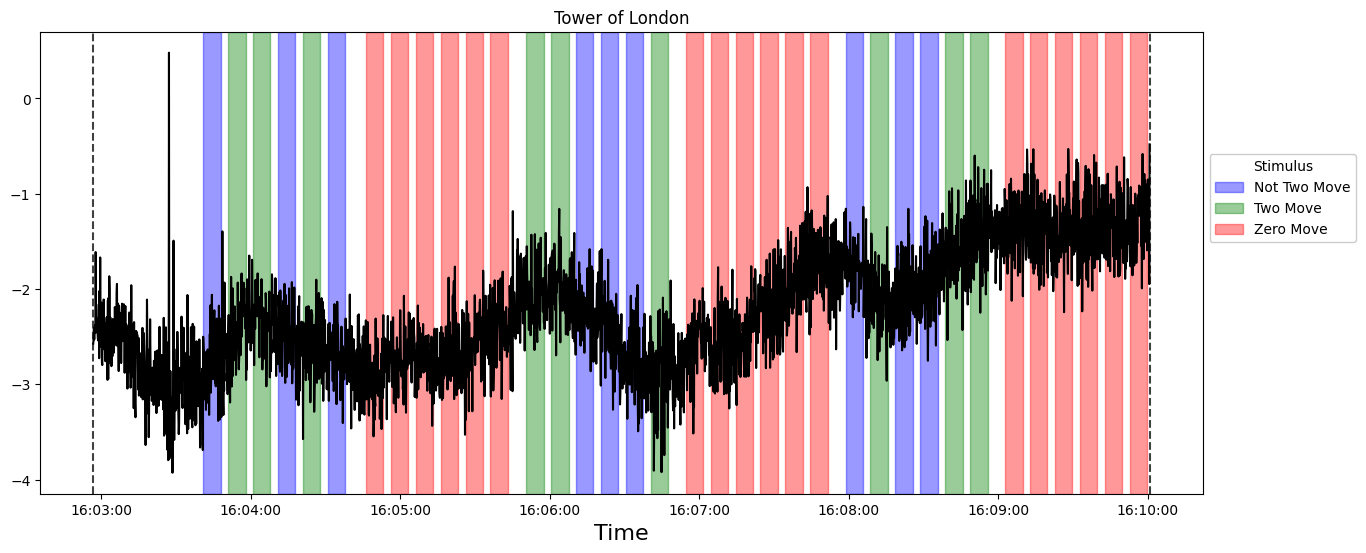

In [54]:
# SNIRF file loading
filepath = r"C:\Kernel\participants\participant_01\flow_data\session_1001\Cog1_S001_2163c20_5.snirf"
flow = Process_Flow(filepath)
par_num = 1
par = Participant_Flow(par_num)
print(par.par_ID)
# snirf_file = flow.load_snirf(filepath=filepath)
# print(snirf_file.nirs[0])
exp_name = "tower_of_london"
exp_results = load_results(r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\results\behavioral", exp_name, par_num)
par.plot_flow_exp(exp_name)

In [8]:
# SNIRF file processing
subject_ID = flow.get_subject_ID()
time_origin_dt = flow.get_time_origin("datetime")
time_origin_ts = flow.get_time_origin("timestamp")
source_dict = flow.create_source_dict()
detector_dict = flow.create_detector_dict()
uni_data_types = flow.get_unique_data_types()
uni_data_type_labels = flow.get_unique_data_type_labels()


In [ ]:
# Time and data processing
time_rel = flow.get_time_rel()
time_abs_dt = flow.get_time_abs("datetime")
time_abs_ts = flow.get_time_abs("timestamp")
data = flow.get_data(0)


AttributeError: 'int' object has no attribute 'lower'